# Kaggle TGS Geoseismic competition

In [3]:
#!pip install -r requirements.txt

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2782968327026120156
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286285517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4007177297723420039
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 4029:00:00.0, compute capability: 3.7"
]


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [2]:
!ls

datalab


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
#!kaggle datasets list

In [4]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 45.3MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 89.5MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 922k/922k [00:00<00:00, 161MB/s]
 92%|█████████████████████████████████████▉   | 151M/163M [00:00<00:00, 133MB/s]
100%|█████████████████████████████████████████| 163M/163M [00:01<00:00, 157MB/s]
 45%|█████████████████                     | 17.0M/37.9M [00:00<00:00, 66.1MB/s]
100%|███████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 124MB/s]


Reference: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

In [6]:
!ls /content

datalab


In [0]:
#!ls /content#/competitions/tgs-salt-identification-challenge

In [0]:
#!mv ~/.kaggle/competitions/tgs-salt-identification-challenge/ /

In [0]:
#!ls /

# Data Exploration

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [7]:
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

C:\Users\Douglas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [3]:
!ls tgs-salt-identification-challenge/testData/

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [4]:
depthFile = pd.read_csv('depths.csv' )
depthFile.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [5]:
depthFile[depthFile['id'] == '4ac19fb269'].z.tolist()[0]

306

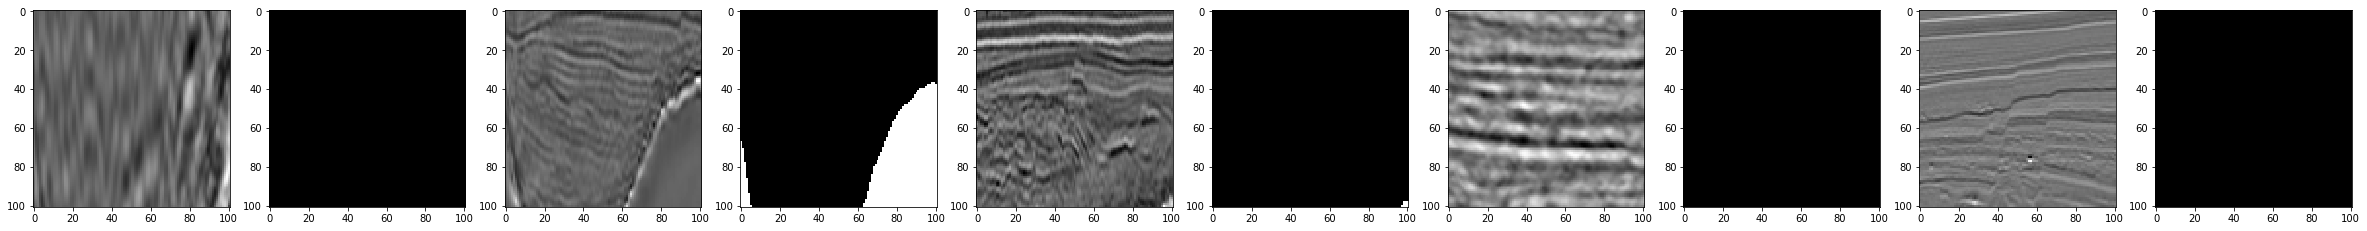

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,25))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(trainFolder + 'images/' + img_name + '.png')
    img_mask = load_img(trainFolder + 'masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [8]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [ ]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print('Mean: {} Std: {}'.format(X_train_mean, X_train_std))
X_train = X_train/255.0#(X_train-X_train_mean)/(2*X_train_std)

#X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
#X_test = (X_test-X_train_mean)/(2*X_train_std)

Getting images and masks ... 


 62%|████████████████████████████████████████████████                              | 2462/4000 [00:31<00:19, 77.60it/s]

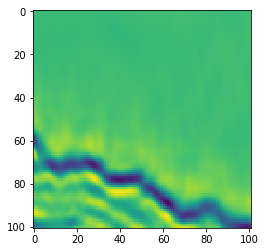

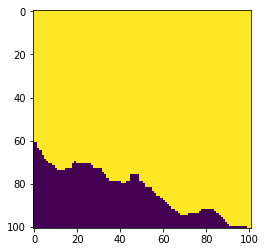

In [10]:
# Check if training data looks all right
ix = np.random.randint(0, len(X_train))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_train[ix,:,:,0])
plt.show()
plt.imshow(Y_train[ix,:,:,0])
plt.show()

# Keras datagen

In [157]:
valRatio = 0.0025
nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}'.format(X_train0.shape, X_val.shape))

(3990, 101, 101, 1), (10, 101, 101, 1)


In [158]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_argsMask = dict(
                     rotation_range=5.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.03, #0
                     width_shift_range=0.35, # 0.03,
                     height_shift_range=0.002, #0.3,
                     horizontal_flip=True,
                     fill_mode = "reflect"
                     #vertical_flip=True #see if helps
                    )

data_gen_args = {}
for key in data_gen_argsMask:
    data_gen_args[key] = data_gen_argsMask[key]
    
#data_gen_args['featurewise_center'] = True
#data_gen_args['featurewise_std_normalization'] = True
#data_gen_args['zca_whitening'] = True #this or normalization

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_argsMask)
depth_datagen = ImageDataGenerator()


seed=7
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
#mask_datagen.fit(Y_train0, augment=True, seed=seed)
#depth_datagen.fit(d_train0, augment=False, seed=seed)

image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=7, batch_size=bSize)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i, X2i], X3i

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) #zip( [image_generator, depth_generator] , [mask_generator] )

668.0


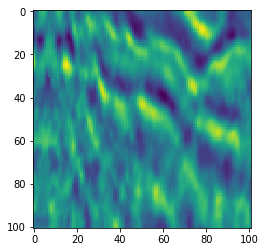

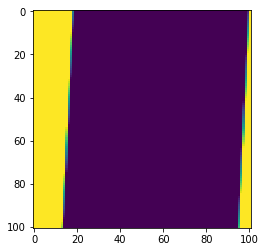

In [13]:
ans = next(train_generator)
print(ans[0][1][17,0,0,0])
plt.imshow( ans[0][0][17,:,:,0] )
plt.show()
plt.imshow( ans[1][17,:,:,0] )
plt.show()

# UNet model

In [14]:
import ModelUNet

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D, Add, Conv2D, Concatenate, SeparableConv2D
from keras.layers.core import Lambda

In [15]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

s=inputImg
dd=inputDepth

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)


#unet = ModelUNet.BuildUNet(convFunction = ModelUNet.ApplyConv, nFilter = 12, net_depth=4, nBorderRefinementConvs = 4)
unet = ModelUNet.BuildSUNet(convFunction = ModelUNet.ApplySepConv, nFilter = 64, net_depth=2, 
                            nBorderRefinementConvs = 4, innerConvs = 16, encoderSquash=64)

su = unet([s,dd])

outputs = su

#outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs) #already in UNet


outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

model = Model(inputs=[inputImg, inputDepth], outputs=[outputs])

model.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
SUNet_d2 (Model)                (None, 128, 128, 1)  2917267     zero_padding2d_1[0][0]           
                                                                 input_2[0][0]                    
__________

## DeepLabV3+

In [24]:
import DeepLabv3Plus

im_height = 101
im_width = 101
im_chan = 1


inputs = Input((im_height, im_width, im_chan))
#s = Lambda(lambda x: x / 255) (inputs)
s=inputs
inputDepth = Input( (1,1,1) )


curLayer = inputs#Concatenate()([inputs, depthIn])


#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (curLayer)
s = Conv2D(3, (1, 1), activation='relu') (s) #(1,1)

dlmodel = DeepLabv3Plus.Deeplabv3(input_shape=(128, 128, 3), classes=21, backbone='xception') #

outputs = dlmodel(s)

dd = Lambda(lambda x: x * 0.001) (inputDepth)
dd = Lambda(lambda x: ModelUNet._expand(x, 128, 128) )(dd)
outputs = Concatenate()([outputs, dd])

#outputs = SeparableConv2D(10, (11, 11), activation='relu', padding = 'same') (outputs)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs)
outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

#freeze some layers
for k in range(len(dlmodel.layers)):
    if k < 299:
        dlmodel.layers[k].trainable = False
    #print('Layer {}: {}, trainable? {}'.format(k, dlmodel.layers[k], dlmodel.layers[k].trainable))

model = Model(inputs=[inputs, inputDepth], outputs=outputs)
model.compile(optimizer='adam', loss=[ModelUNet.dice_loss], metrics=[ModelUNet.mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 128, 128, 1)  0           input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 3)  6           zero_padding2d_22[0][0]          
__________________________________________________________________________________________________
lambda_7 (

# Training

In [191]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.0001                
    drop = 0.6
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 5e-7):
        lrate = 5e-7
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [192]:
earlystopper = EarlyStopping(patience=175, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
internalEval = ModelUNet.IntervalEvaluation( validation_data=( [X_val, d_val], Y_val), interval = 1 )
#results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
#                    callbacks=[earlystopper, checkpointer, lrate])

results = model.fit_generator(train_generator, epochs=300, steps_per_epoch=len(X_train0) / 32, 
                              validation_data=( [X_val, d_val], Y_val),
                              callbacks=[earlystopper, checkpointer, lrate, internalEval])


Epoch 1/300
Changing learning rate to 0.0001
 57/124 [============>.................] - ETA: 1:22 - loss: 0.0041 - mean_iou: 0.9191

KeyboardInterrupt: 

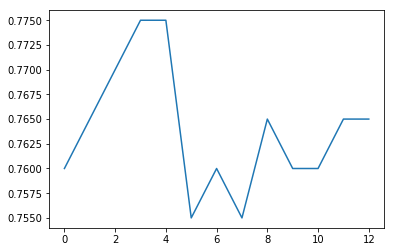

In [129]:
plt.plot(internalEval.score_list[4:])

In [101]:
# list all data in history
print(results.history.keys())

dict_keys(['val_loss', 'loss', 'val_mean_iou', 'mean_iou'])


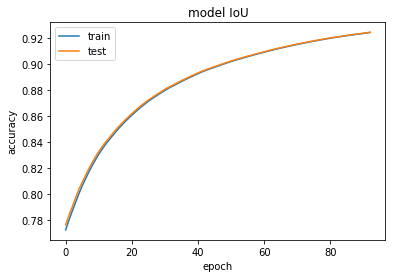

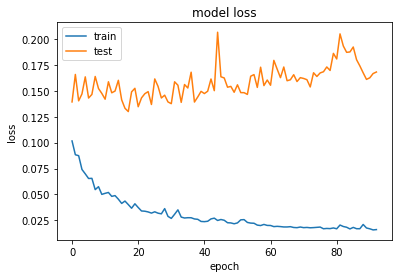

In [102]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
model = load_model('model-tgs-salt-IV.h5', custom_objects={'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, 
                                                           '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [52]:
#from google.colab import files
#files.download('model-tgs-salt-1.h5')
#files.upload()

In [53]:
#for i in tqdm(range(len(X_train0))):
#    X_train0[i] = image_datagen.standardize(X_train0[i].astype(float))
    
#for i in tqdm(range(len(X_val))):
#    X_val[i] = image_datagen.standardize(X_val[i].astype(float))

In [193]:
preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val,d_val], verbose=1)

10/10 [==============================] - 0s 16ms/step


## Watershed

In [194]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(65)):
    thresh = 0.3 + 0.7*(1+kk)/65
    threshList.append(thresh)
    
    meanIoUVal = 0
    
    preds_val_ws = ModelUNet.WaterShedChangeAll(preds_val, lowThresh = 0.1, highThresh = thresh)
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_ws[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )
    

100%|██████████| 65/65 [00:02<00:00, 23.18it/s]]


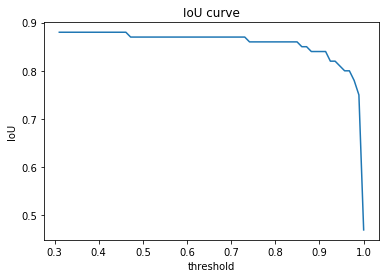

In [195]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

#plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [196]:
wsThresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(wsThresh, max(IoUValList)))

Thresh: 0.31076923076923074  ExpectedIoU: 0.8800000000000001


## Threshold optimization

In [197]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(13)):
    thresh = (1+kk)/13
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([ModelUNet.IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )

100%|██████████| 13/13 [01:18<00:00,  6.03s/it]


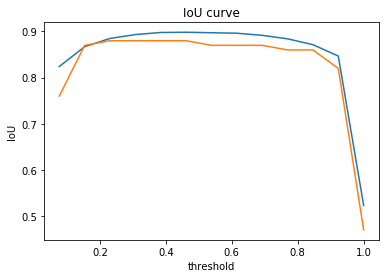

In [198]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [199]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.23076923076923078  ExpectedIoU: 0.8800000000000001


In [200]:
thresh = 0.5

# Joint Optimization of Pixel Count and Threshold

In [174]:
def AdapThresh(pred_logits, threshPixels, thresh, threshL, threshH):
    pred_t = np.zeros_like(pred_logits)
    for i in range(len(pred_logits)):
        pred_t[i] = (pred_logits[i] > thresh).astype(np.uint8)
        if pred_t[i].sum() > threshPixels:
            pred_t[i] = (pred_logits[i] > threshL).astype(np.uint8)
        else:
            pred_t[i] = (pred_logits[i] > threshH).astype(np.uint8)
    return pred_t

def ComputeIoU(pred_logits, G0, threshPixels, thresh, threshL, threshH):
    pred_t = AdapThresh(pred_logits, threshPixels, thresh, threshL, threshH)
    meanIoUVal = np.array([ModelUNet.IoU(pred_t[i].astype(np.uint8), G0[i].astype(np.uint8)) for i in range(G0.shape[0])])
    return np.mean(meanIoUVal)

In [175]:
#threshold pixels, threshold value, threshold low (high pix count), threshold high (low pix count)
parameters = []
nRuns = 3000
bestSoFar = 0
for k in tqdm(range(nRuns)):
    threshPix = np.random.randint(1,101*30)
    threshM = 0.3+0.7*np.random.random()
    threshL = threshM*np.random.random()
    threshH = threshM + (1 - threshM)*np.random.random()
    
    meanIoU = ComputeIoU(preds_val, Y_val, threshPix, threshM, threshL, threshH)
    if meanIoU > bestSoFar:
        bestSoFar = meanIoU
        print('Best mean IoU improved to {}'.format(bestSoFar))
    parameters.append([threshPix, threshM, threshL, threshH, meanIoU])
    
parameters = np.array(parameters)

bestparams = np.array([parameters[q] for q in range(len(parameters)) if parameters[q,4] == bestSoFar])

#print('Best set of parameters: {}'.format(parameters[ np.argmax(parameters,0)[4] ]))
print('Best set of parameters: {}'.format(bestparams[:,0:4]))
print(np.argmax(parameters,0))
#print(parameters)


  0%|          | 7/3000 [00:00<00:48, 62.32it/s]

Best mean IoU improved to 0.8699999999999999
Best mean IoU improved to 0.8800000000000001


 91%|█████████ | 2723/3000 [00:43<00:04, 62.82it/s]

Best mean IoU improved to 0.89


100%|██████████| 3000/3000 [00:47<00:00, 62.78it/s]

Best set of parameters: [[2.73000000e+02 4.09481043e-01 1.72299956e-01 8.70076138e-01]]
[1090   28 1542   28 2714]


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   0.,   1.,   2.,   4.,   0.,  19.,   6.,   1.,   6.,
          0.,  19.,   0.,  34.,  26.,   0.,  37.,   4.,  35.,  77.,   0.,
        108.,   2.,  68., 188.,   0., 232.,   0., 158., 311.,   0., 307.,
          0., 403., 549.,   0., 398.,   1.]),
 array([0.59 , 0.596, 0.602, 0.608, 0.614, 0.62 , 0.626, 0.632, 0.638,
        0.644, 0.65 , 0.656, 0.662, 0.668, 0.674, 0.68 , 0.686, 0.692,
        0.698, 0.704, 0.71 , 0.716, 0.722, 0.728, 0.734, 0.74 , 0.746,
        0.752, 0.758, 0.764, 0.77 , 0.776, 0.782, 0.788, 0.794, 0.8  ,
        0.806, 0.812, 0.818, 0.824, 0.83 , 0.836, 0.842, 0.848, 0.854,
        0.86 , 0.866, 0.872, 0.878, 0.884, 0.89 ]),
 <a list of 50 Patch objects>)

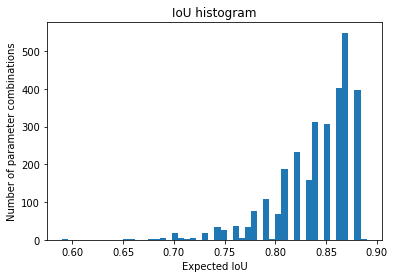

In [177]:
plt.title('IoU histogram')
plt.ylabel('Number of parameter combinations')
plt.xlabel('Expected IoU')

plt.hist(parameters[:,4], bins=50)

In [178]:
threshPixels=2.73000000e+02 
threshM= 4.09481043e-01 
threshL= 1.72299956e-01 
threshH= 8.70076138e-01

# Predictions

In [143]:
X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
X_test = X_test/255.0 #(X_test-X_train_mean)/(2*X_train_std)

#for i in tqdm(range(len(X_test))):
#    X_test[i] = image_datagen.standardize(X_test[i].astype(float))

  0%|          | 0/18000 [00:00<?, ?it/s]

Getting images and masks ... 


100%|██████████| 18000/18000 [10:01<00:00, 29.95it/s]


In [201]:
model_array = [
               #load_model('model-tgs-salt-Resnet.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-ReflecConv.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-Incep1.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
              ]

# Predict on train, val and test

preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)
preds_test = model.predict([X_test, d_test], verbose=1)

for savedModel in model_array:
    preds_train += savedModel.predict([X_train0, d_train0], verbose=1)
    preds_val += savedModel.predict([X_val, d_val], verbose=1)
    preds_test += savedModel.predict([X_test, d_test], verbose=1)

preds_train /= 1+len(model_array)
preds_val /= 1+len(model_array)
preds_test /= 1+len(model_array)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 236s 13ms/step


In [180]:
#Watershed predictions
#preds_test_t = ModelUNet.WaterShedChangeAll(preds_test, lowThresh = 0.1, highThresh = wsThresh)

In [181]:
#quadruple-threshold preds
preds_test_t = AdapThresh(preds_test, threshPixels, threshM, threshL, threshH)

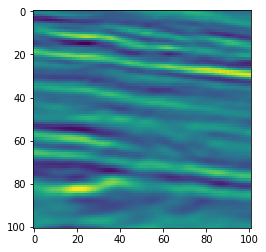

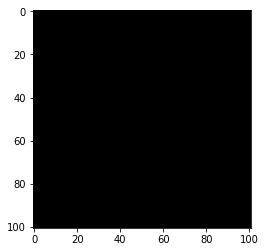

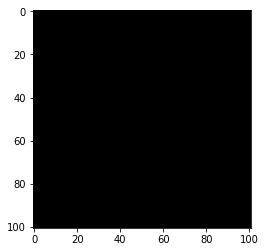

In [182]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train0[ix,:,:,0])
plt.show()
#plt.imshow(Y_train[ix,:,:,0])
tmp = np.squeeze(Y_train0[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [183]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 5 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

61

In [184]:
testEmptyIDs = [imgId for imgId in range(len(preds_test)) if preds_test[imgId].max() < 0.1]
nonSaltTestImgs = X_test[testEmptyIDs]
nonSaltTestDpth = d_test[testEmptyIDs]
len(testEmptyIDs)

6239

In [185]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [202]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [203]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

18000it [04:38, 64.68it/s]


In [204]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [205]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [206]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "DeepLabv3, initial_lr=.001, thresh, backbone=xception"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('submission.zip')